# Train Stats

```
 ----------------------------------------------------------------------------------------
/                                                                                        \
| /$$$$$$$$                 /$$            /$$$$$$   /$$                 /$$             |
||__  $$__/                |__/           /$$__  $$ | $$                | $$             |
|   | $$  /$$$$$$  /$$$$$$  /$$ /$$$$$$$ | $$  \__//$$$$$$    /$$$$$$  /$$$$$$   /$$$$$$$|
|   | $$ /$$__  $$|____  $$| $$| $$__  $$|  $$$$$$|_  $$_/   |____  $$|_  $$_/  /$$_____/|
|   | $$| $$  \__/ /$$$$$$$| $$| $$  \ $$ \____  $$ | $$      /$$$$$$$  | $$   |  $$$$$$ |
|   | $$| $$      /$$__  $$| $$| $$  | $$ /$$  \ $$ | $$ /$$ /$$__  $$  | $$ /$$\____  $$|
|   | $$| $$     |  $$$$$$$| $$| $$  | $$|  $$$$$$/ |  $$$$/|  $$$$$$$  |  $$$$//$$$$$$$/|
|   |__/|__/      \_______/|__/|__/  |__/ \______/   \___/   \_______/   \___/ |_______/ |
|                                                                                        |
|                                                                                        |
|                                                                                        |
|                                      🚂 ¯\_(ツ)_/¯?                                     |
\                                                                                        /
 ----------------------------------------------------------------------------------------
    \     
     \     
      \      
           ___ ____
         ⎛   ⎛ ,----
          \  //==--'
     _//|,.·//==--'    ____________________________
    _OO≣=-  ︶ ᴹw ⎞_§ ______  ___\ ___\ ,\__ \/ __ \
   (∞)_, )  (     |  ______/__  \/ /__ / /_/ / /_/ /
     ¨--¨|| |- (  / ______\____/ \___/ \__^_/  .__/
         ««_/  «_/ jgs/bd808                /_/
```

In which I look at data from the past several hundred trains and pretend that I know how to do exploratory data analysis.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

with open('data/TRAINS') as f:
    TRAINS = [x.strip() for x in f.readlines()]

engine = create_engine('sqlite:///data/train.db')
df = pd.read_sql('''
SELECT
    version,
    rollbacks,
    rollbacks_time,
    group2_delay_days,
    (group0_delay_days +
     group1_delay_days +
     group2_delay_days) as total_delay,
    total_time as train_total_time,
    (select count(*) from blocker b where b.train_id = t.id) as blockers,
    (select count(*) from blocker b where b.train_id = t.id and resolved = 1) as resolved_blockers,
    patches,
    (select max(time_in_review) from patch p where p.train_id = t.id) as max_time_in_review,
    (select max(comments) from patch where patch.train_id = t.id) as max_comments_per_patch,
    (select max(start_time - created) from patch p where p.train_id = t.id) as max_cycle_time
FROM train t
''', engine)

# Makes your data 538% better...I think
plt.style.use('fivethirtyeight')
df.head()

,version,rollbacks,rollbacks_time,group2_delay_days,total_delay,train_total_time,blockers,resolved_blockers,patches,max_time_in_review,max_comments_per_patch,max_cycle_time
0,1.37.0-wmf.1,0,0,0,0,178349,5,3,450,36809044.0,27.0,36952873.0
1,1.37.0-wmf.3,3,94493,0,1,219880,7,6,366,56122286.0,30.0,56562620.0
2,1.37.0-wmf.4,1,66812,1,3,263742,9,4,422,38820872.0,29.0,38982601.0
3,1.36.0-wmf.1,0,0,4,4,519622,1,1,566,47181045.0,31.0,47755190.0
4,1.36.0-wmf.2,4,389769,4,5,554704,7,1,273,110996452.0,33.0,111569626.0


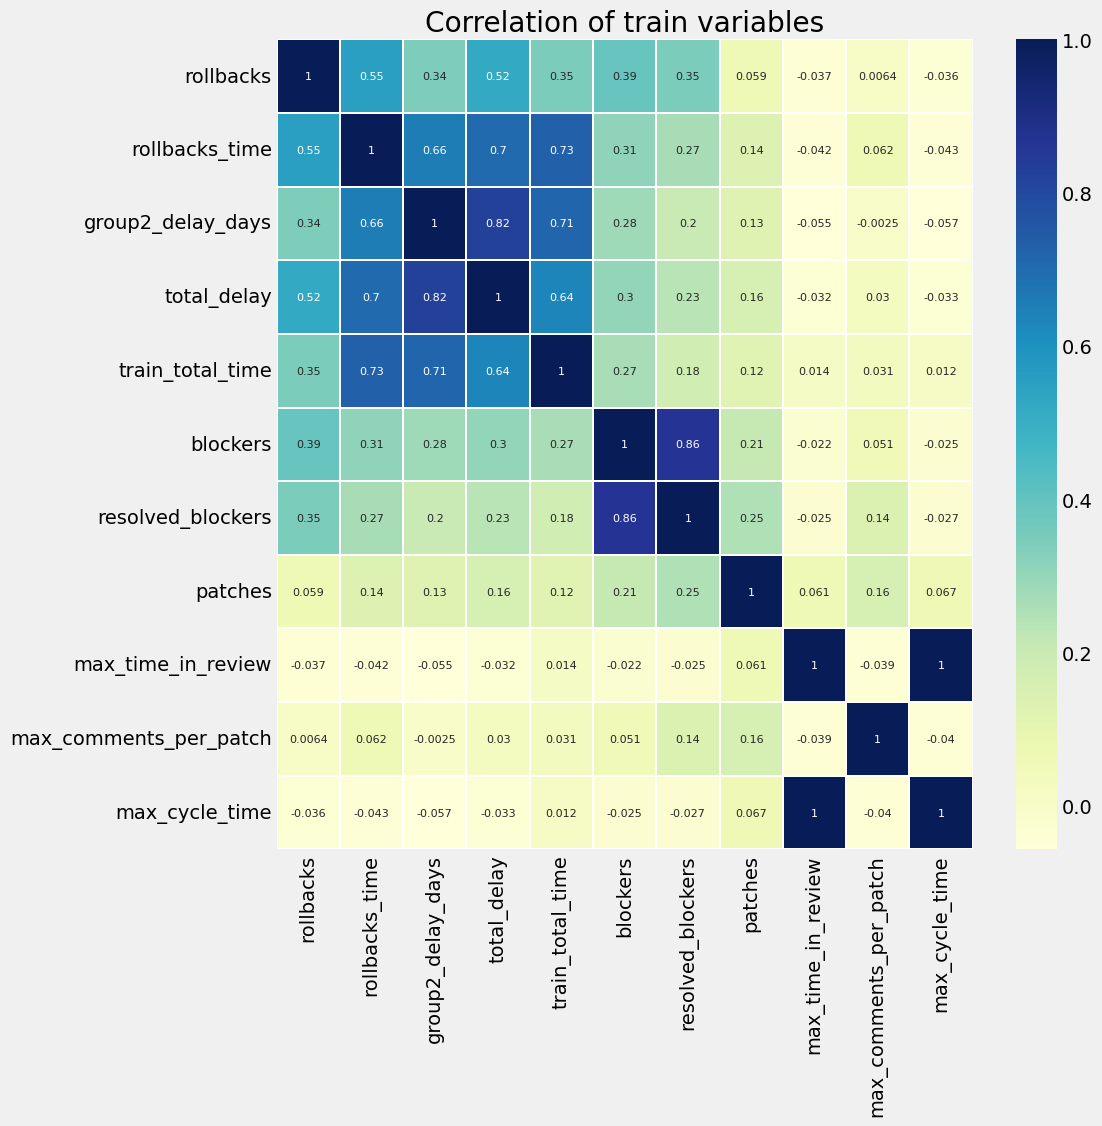

In [2]:
df_corr = df.copy(deep=True)
df_corr.drop(['version'], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_corr.corr(), annot=True, cmap="YlGnBu", linewidths=0.3, annot_kws={"size": 8}, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation of train variables')
plt.show()

Text(0.5, 1.02, 'Blockers per Train')

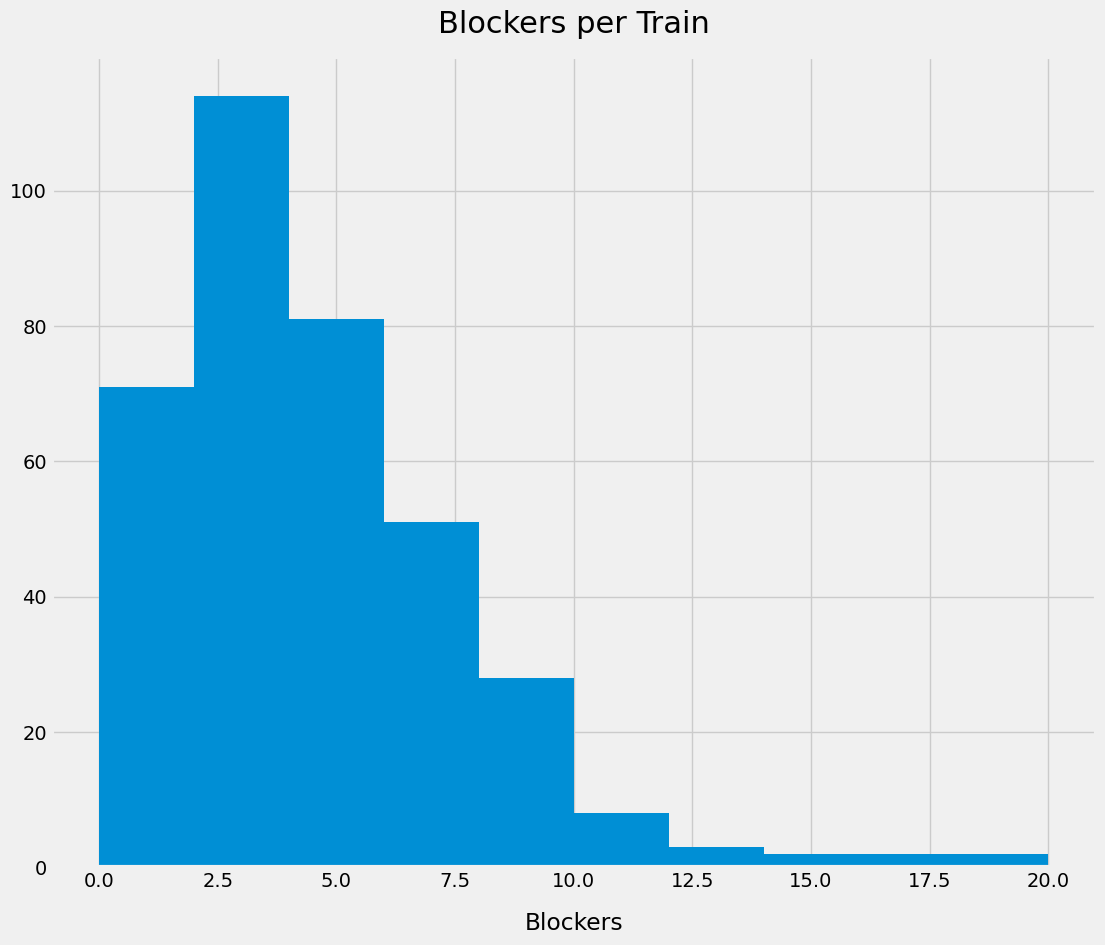

In [3]:
df.set_index('version')['blockers'].hist(figsize=(12, 10))
plt.xlabel("Blockers", labelpad=15)
plt.title("Blockers per Train", y=1.02, fontsize=22)

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(-50.0, 0, '−50'),
  Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250'),
  Text(300.0, 0, '300'),
  Text(350.0, 0, '350'),
  Text(400.0, 0, '400')])

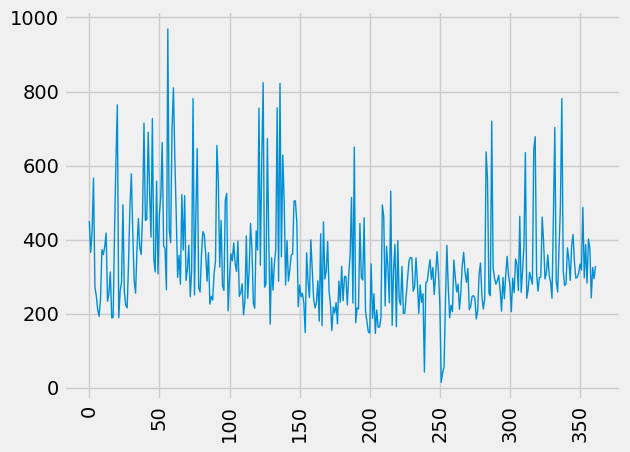

In [4]:
df.patches.plot(linewidth=1)
plt.xticks(rotation=90)

In [5]:
df[df['blockers'] > 10].sort_values(by='blockers', ascending=False)

,version,rollbacks,rollbacks_time,group2_delay_days,total_delay,train_total_time,blockers,resolved_blockers,patches,max_time_in_review,max_comments_per_patch,max_cycle_time
82,1.34.0-wmf.20,1,16897,5,5,600096,20,11,413,60583935.0,37.0,60715205.0
242,1.38.0-wmf.19,1,70250,0,1,176801,18,10,319,85391889.0,24.0,85778365.0
103,1.33.0-wmf.22,0,0,0,1,63844,17,11,391,107411197.0,45.0,107659715.0
77,1.34.0-wmf.14,2,412678,4,5,524983,16,7,646,73502579.0,34.0,73539481.0
136,1.31.0-wmf.20,2,134534,1,5,255075,14,12,822,66099647.0,75.0,67210868.0
210,1.30.0-wmf.2,2,595079,0,0,782668,14,12,462,67958577.0,56.0,68943029.0
241,1.38.0-wmf.18,0,0,0,0,171956,13,7,287,186407187.0,43.0,186862129.0
124,1.32.0-wmf.22,0,0,0,0,173055,12,7,824,64869761.0,44.0,65392036.0
259,1.39.0-wmf.10,5,57256,0,1,172544,12,5,206,89212513.0,22.0,89427805.0
57,1.35.0-wmf.31,3,365118,4,15,516489,11,7,427,72215548.0,70.0,72206585.0


In [6]:
block_df = pd.read_sql('''
SELECT
    version,
    group_blocked
FROM train t
JOIN blocker b ON t.id = b.train_id
''', engine)
block_df.head()

,version,group_blocked
0,1.37.0-wmf.7,-1
1,1.37.0-wmf.7,-1
2,1.37.0-wmf.12,2
3,1.37.0-wmf.12,1
4,1.37.0-wmf.12,1


In [7]:
block_df.group_blocked.unique()

array([-1,  2,  1,  0])

In [8]:
group_name_map = {
    -1: "Earlier",
    0: "Group0",
    1: "Group1",
    2: "Group2",
}
block_df['blocker_added'] = block_df.group_blocked.map(group_name_map)
block_df.head()

,version,group_blocked,blocker_added
0,1.37.0-wmf.7,-1,Earlier
1,1.37.0-wmf.7,-1,Earlier
2,1.37.0-wmf.12,2,Group2
3,1.37.0-wmf.12,1,Group1
4,1.37.0-wmf.12,1,Group1


In [9]:
block_df.group_blocked.value_counts()

group_blocked
-1    557
 1    423
 0    352
 2    145
Name: count, dtype: int64

In [10]:
block_df.version

0        1.37.0-wmf.7
1        1.37.0-wmf.7
2       1.37.0-wmf.12
3       1.37.0-wmf.12
4       1.37.0-wmf.12
            ...      
1472    1.43.0-wmf.10
1473    1.43.0-wmf.10
1474    1.43.0-wmf.11
1475    1.43.0-wmf.14
1476    1.43.0-wmf.14
Name: version, Length: 1477, dtype: object

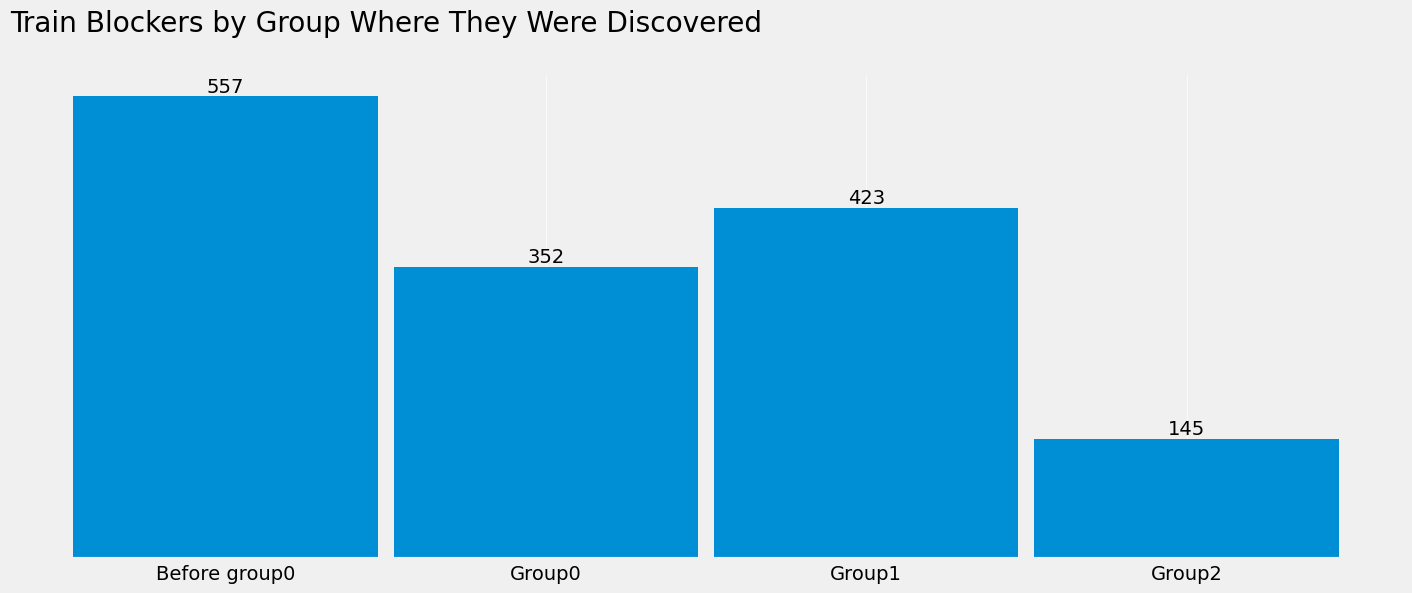

In [11]:
block_df.set_index('version')
block_df.sort_values('group_blocked', inplace=True)


fig = plt.figure(figsize=(16,6))
plt.grid(color='white', lw=0.5, axis='x')
n, bins, patches = plt.hist(block_df.blocker_added, bins=4, rwidth=0.95)

xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
xticks_labels = [ "{:.2f}\nto\n{:.2f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels=["Before group0", "Group0", "Group1", "Group2"])

# remove y ticks
plt.yticks([])

# plot values on top of bars
for idx, value in enumerate(n):
    if value > 0:
        plt.text(xticks[idx], value+5, int(value), ha='center')

plt.title('Train Blockers by Group Where They Were Discovered', loc='left', pad=30)
plt.show()


In [12]:
patches = pd.read_sql('''
SELECT
    link,
    version,
    submitted,
    insertions as ins,
    (deletions*-1) as del
FROM patch p JOIN train t ON t.id = p.train_id
''', engine)
patches.describe()

,submitted,ins,del
count,1.211040e+05,1.211040e+05,1.211040e+05
mean,1.594790e+09,2.905992e+02,-2.304868e+02
std,7.380635e+07,4.987077e+04,4.781698e+04
min,1.431572e+09,0.000000e+00,-1.661412e+07
25%,1.535820e+09,2.000000e+00,-1.800000e+01
50%,1.590864e+09,7.000000e+00,-4.000000e+00
75%,1.659399e+09,3.400000e+01,-1.000000e+00
max,1.721720e+09,1.728860e+07,0.000000e+00


In [13]:
patches['loc'] = patches['ins'] + patches['del']
patches.head()

,link,version,submitted,ins,del,loc
0,"https://gerrit.wikimedia.org/r/#/q/ccbfcf28,n,z",1.37.0-wmf.1,1618945759,5,-1,4
1,"https://gerrit.wikimedia.org/r/#/q/3302274f,n,z",1.37.0-wmf.1,1618878371,1156,-660,496
2,"https://gerrit.wikimedia.org/r/#/q/8b5471b5,n,z",1.37.0-wmf.1,1618343309,976,-3,973
3,"https://gerrit.wikimedia.org/r/#/q/a6abbb67,n,z",1.37.0-wmf.1,1618341075,8,-29,-21
4,"https://gerrit.wikimedia.org/r/#/q/af916aad,n,z",1.37.0-wmf.1,1618300868,7,-5,2


In [14]:
patches['submitted'] = pd.to_datetime(patches['submitted'], unit='s')
patches.set_index('submitted', inplace=True)

In [15]:
out = patches.groupby(pd.Grouper(freq='M')).apply(lambda x: x)
out = out[out['link'] != 'https://gerrit.wikimedia.org/r/#/q/9a08dbab,n,z'] # The one patch that inserts 17.2M lines of code
out['ok'] = out['loc'].cumsum()

## Cycle time/Lead time

**Cycle time** is the time from when a patch enters code review to the time that it's in production. **Lead time** is the time it takes from commit to production.

In [16]:
# GOAL
#         train     lead_time    cycle_time   Id
# 0    1.37.0-wmf.6    200   2000   u1234
# 1    1.37.0-wmf.6    123   2800   u1235

cycle = pd.read_sql('''
SELECT
    substr(version, 8) as version,
    datetime(start_time, 'unixepoch'),
    (start_time - created) as cycle_time,
    (start_time - submitted) as lead_time,
    datetime(created, 'unixepoch'),
    datetime(submitted, 'unixepoch'),
    link
FROM patch p JOIN train t ON t.id = p.train_id
WHERE (lead_time > 0 AND cycle_time > 0)
    AND (
        version = "%(version_one)s" OR
        version = "%(version_two)s" OR
        version = "%(version_three)s"
    )
''' % {
    'version_one': TRAINS[0],
    'version_two': TRAINS[1],
    'version_three': TRAINS[2],
}, engine)
cycle.head()

,version,"datetime(start_time, 'unixepoch')",cycle_time,lead_time,"datetime(created, 'unixepoch')","datetime(submitted, 'unixepoch')",link
0,wmf.13,2024-07-09 03:01:49,278136,4697,2024-07-05 21:46:13,2024-07-09 01:43:32,https://gerrit.wikimedia.org/r/1052323
1,wmf.13,2024-07-09 03:01:49,623669,11770,2024-07-01 21:47:20,2024-07-08 23:45:39,https://gerrit.wikimedia.org/r/1051158
2,wmf.13,2024-07-09 03:01:49,28504,14957,2024-07-08 19:06:45,2024-07-08 22:52:32,https://gerrit.wikimedia.org/r/1052734
3,wmf.13,2024-07-09 03:01:49,29362,10897,2024-07-08 18:52:27,2024-07-09 00:00:12,https://gerrit.wikimedia.org/r/1052732
4,wmf.13,2024-07-09 03:01:49,42050,25037,2024-07-08 15:20:59,2024-07-08 20:04:32,https://gerrit.wikimedia.org/r/1052679


In [17]:
cycle.sort_values(by='lead_time', ascending=False).head()

,version,"datetime(start_time, 'unixepoch')",cycle_time,lead_time,"datetime(created, 'unixepoch')","datetime(submitted, 'unixepoch')",link
727,wmf.15,2024-07-23 03:01:50,9643659,9616185,2024-04-02 12:14:11,2024-04-02 19:52:05,https://gerrit.wikimedia.org/r/1016082
726,wmf.15,2024-07-23 03:01:50,8146006,8112502,2024-04-19 20:15:04,2024-04-20 05:33:28,https://gerrit.wikimedia.org/r/1021962
725,wmf.15,2024-07-23 03:01:50,9613450,7951774,2024-04-02 20:37:40,2024-04-22 02:12:16,https://gerrit.wikimedia.org/r/1016353
724,wmf.15,2024-07-23 03:01:50,8733315,7951772,2024-04-13 01:06:35,2024-04-22 02:12:18,https://gerrit.wikimedia.org/r/1019332
723,wmf.15,2024-07-23 03:01:50,8637969,7951463,2024-04-14 03:35:41,2024-04-22 02:17:27,https://gerrit.wikimedia.org/r/1019404


### Lead time

The time from commit to deploy (in seconds)

In [18]:
cycle['lead_time_days'] = cycle['lead_time'] / (60*60*24)
cycle['cycle_time_days'] = cycle['cycle_time'] / (60*60*24)
cycle.sort_values(by='lead_time_days').head()

,version,"datetime(start_time, 'unixepoch')",cycle_time,lead_time,"datetime(created, 'unixepoch')","datetime(submitted, 'unixepoch')",link,lead_time_days,cycle_time_days
599,wmf.15,2024-07-23 03:01:50,1932,255,2024-07-23 02:29:38,2024-07-23 02:57:35,https://gerrit.wikimedia.org/r/1056015,0.002951,0.022361
325,wmf.14,2024-07-16 03:01:50,259232,307,2024-07-13 03:01:18,2024-07-16 02:56:43,https://gerrit.wikimedia.org/r/1053989,0.003553,3.000370
601,wmf.15,2024-07-23 03:01:50,423783,758,2024-07-18 05:18:47,2024-07-23 02:49:12,https://gerrit.wikimedia.org/r/1054954,0.008773,4.904896
678,wmf.15,2024-07-23 03:01:50,89628,829,2024-07-22 02:08:02,2024-07-23 02:48:01,https://gerrit.wikimedia.org/r/1055616,0.009595,1.037361
519,wmf.14,2024-07-16 03:01:50,356295,1105,2024-07-12 00:03:35,2024-07-16 02:43:25,https://gerrit.wikimedia.org/r/1053754,0.012789,4.123785


/tmp/ipykernel_3593921/2853478908.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)
/home/thcipriani/Projects/Wikimedia/train-stats/venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 62.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/thcipriani/Projects/Wikimedia/train-stats/venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 56.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/thcipriani/Projects/Wikimedia/train-stats/venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 52.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/thcipriani/Projects/Wikimedia/train-stats/venv/lib/python3.11/site-packages/seaborn/cat

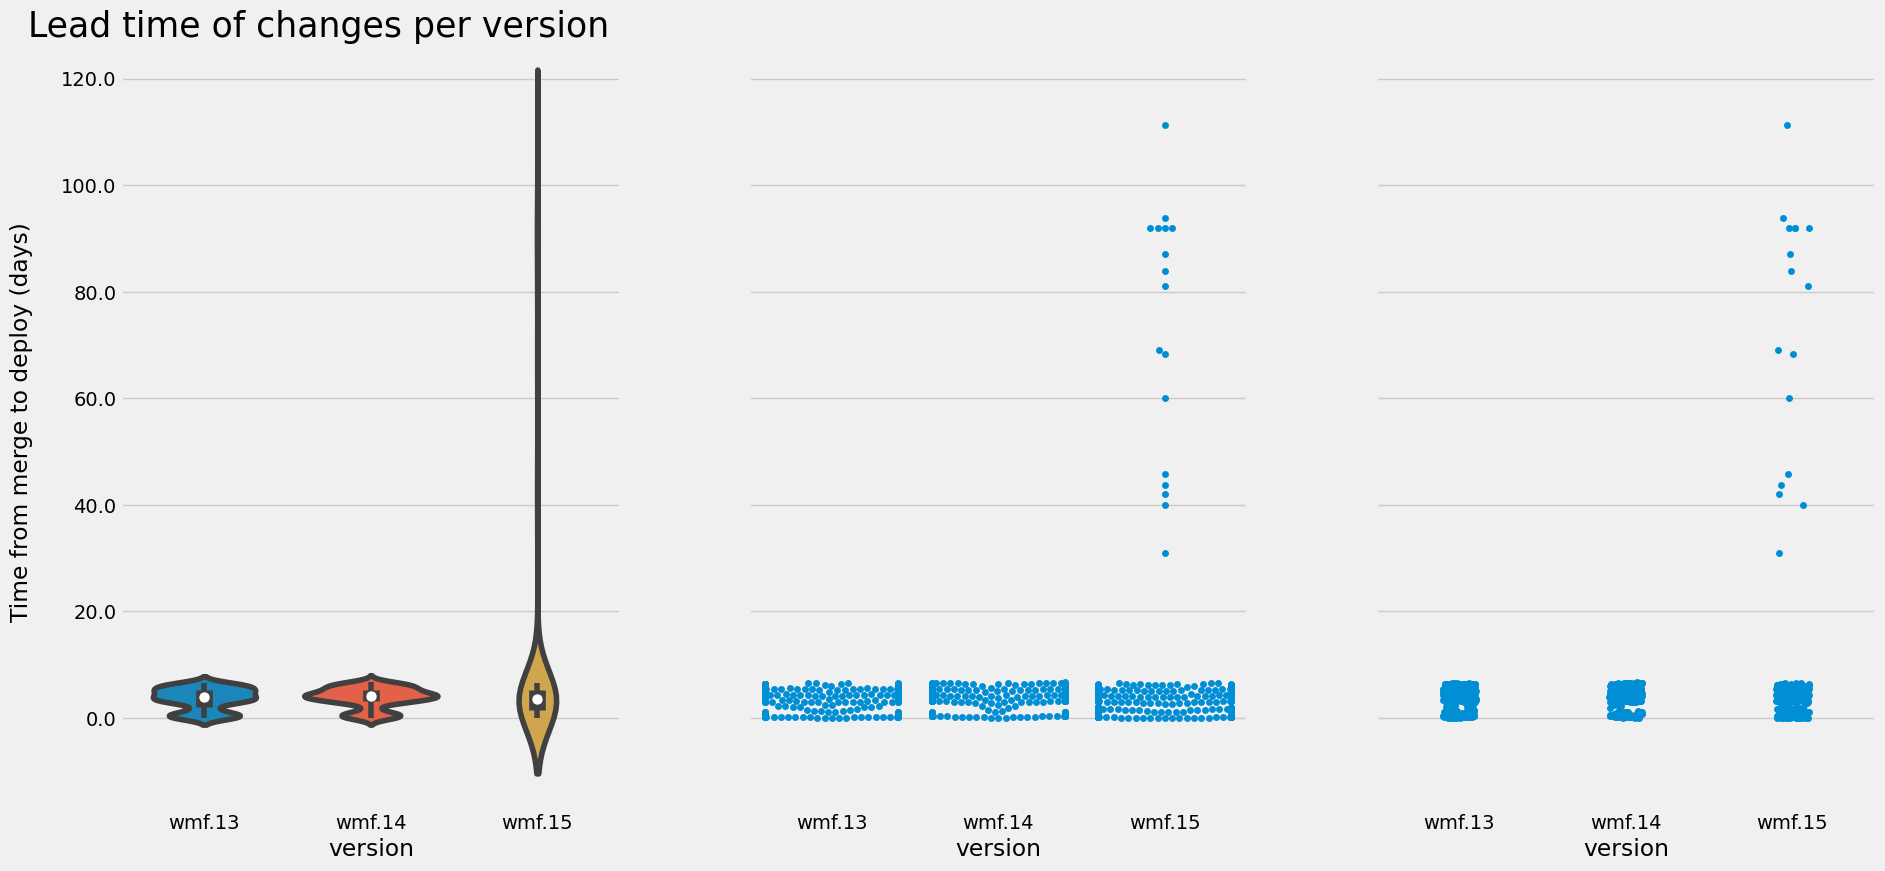

In [19]:
from matplotlib import ticker as mticker
import numpy as np

# Adapted from <https://stackoverflow.com/a/60132262>
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10), constrained_layout=True)
plt.tight_layout(pad=5)
sns.violinplot(data=cycle,x='version', y='lead_time_days', ax=ax[0])
sns.swarmplot(data=cycle,x='version', y='lead_time_days', ax=ax[1])
sns.stripplot(data=cycle,x='version', y='lead_time_days', ax=ax[2])
ax[0].set_ylabel('Time from merge to deploy (days)', labelpad=20.0)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))

plt.suptitle('Lead time of changes per version', x=0.02, y=.92, ha='left', fontsize=25)
plt.show()

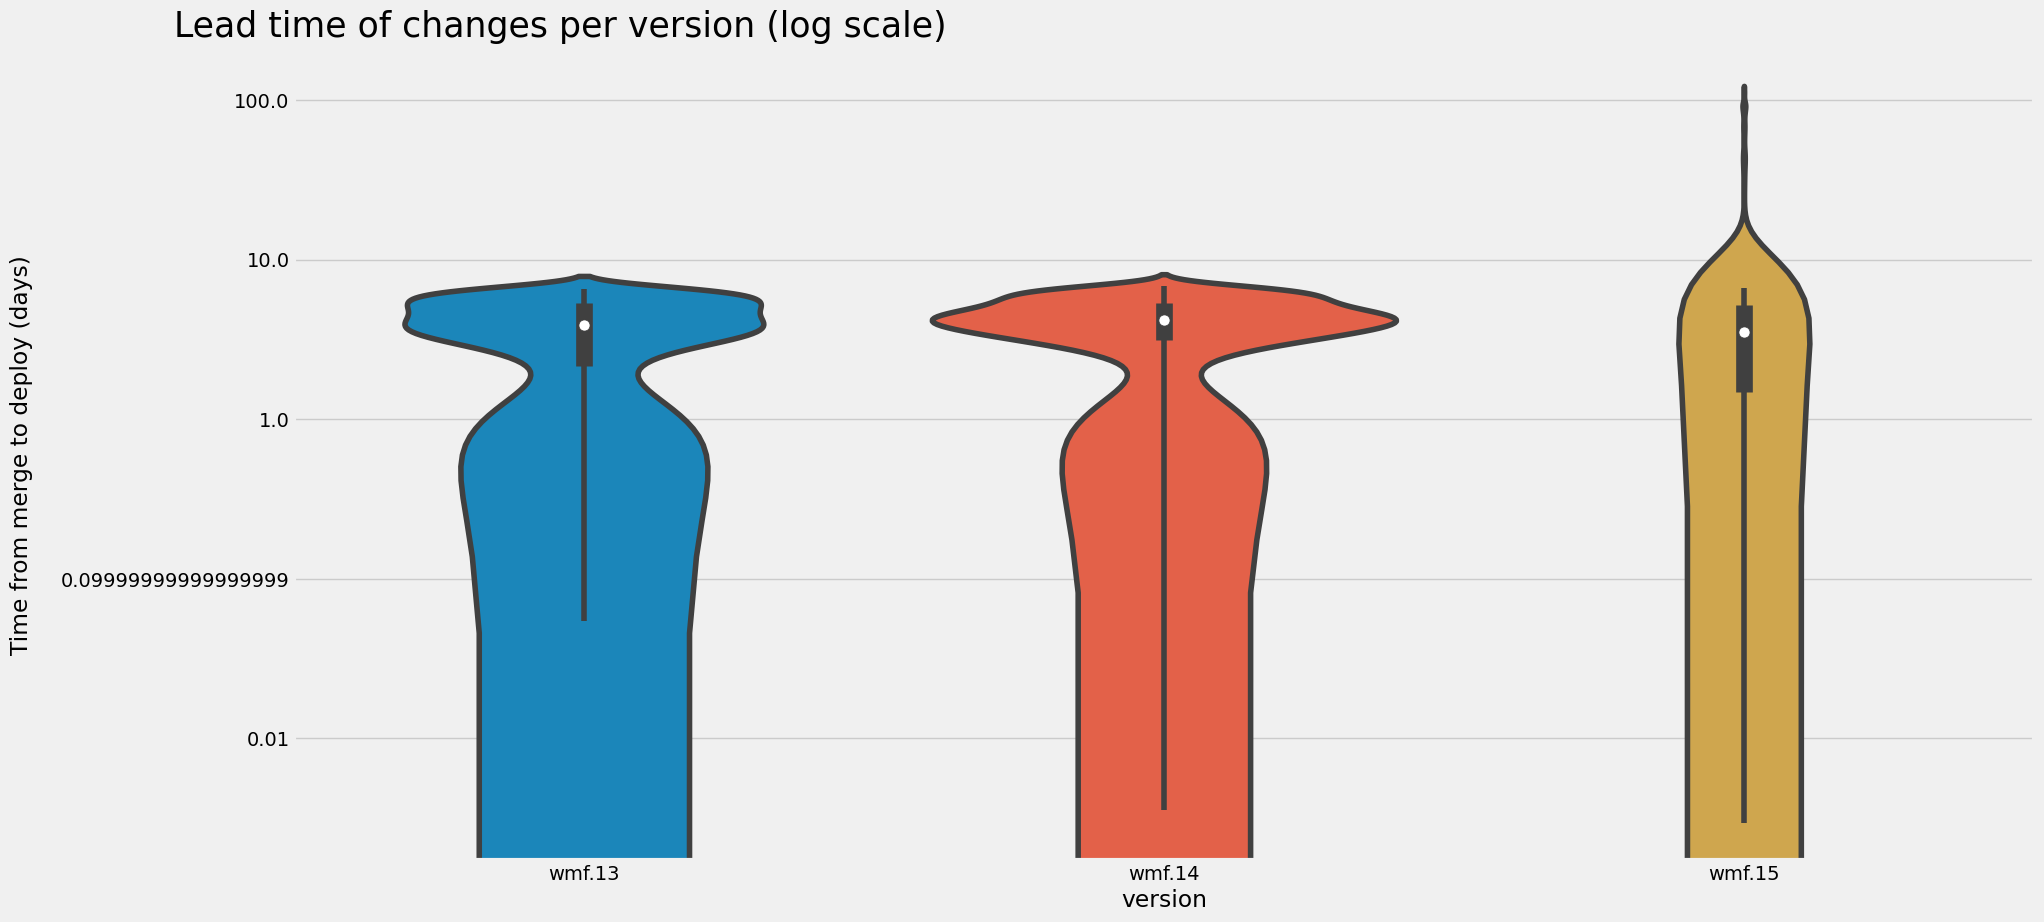

In [20]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(20,10))
ax.set_yscale('log')
sns.violinplot(data=cycle,x='version', y='lead_time_days', ax=ax)
ax.set_ylabel('Time from merge to deploy (days)', labelpad=20.0)

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
plt.suptitle('Lead time of changes per version (log scale)', x=0.02, y=.92, ha='left', fontsize=25)
plt.show()

### Cycle time

The time from patchset submission for code review to deploy

/home/thcipriani/Projects/Wikimedia/train-stats/venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 79.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/thcipriani/Projects/Wikimedia/train-stats/venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 78.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/thcipriani/Projects/Wikimedia/train-stats/venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 74.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/thcipriani/Projects/Wikimedia/train-stats/venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 83.6% of the points cannot be placed; you may want to decrease the size of the markers 

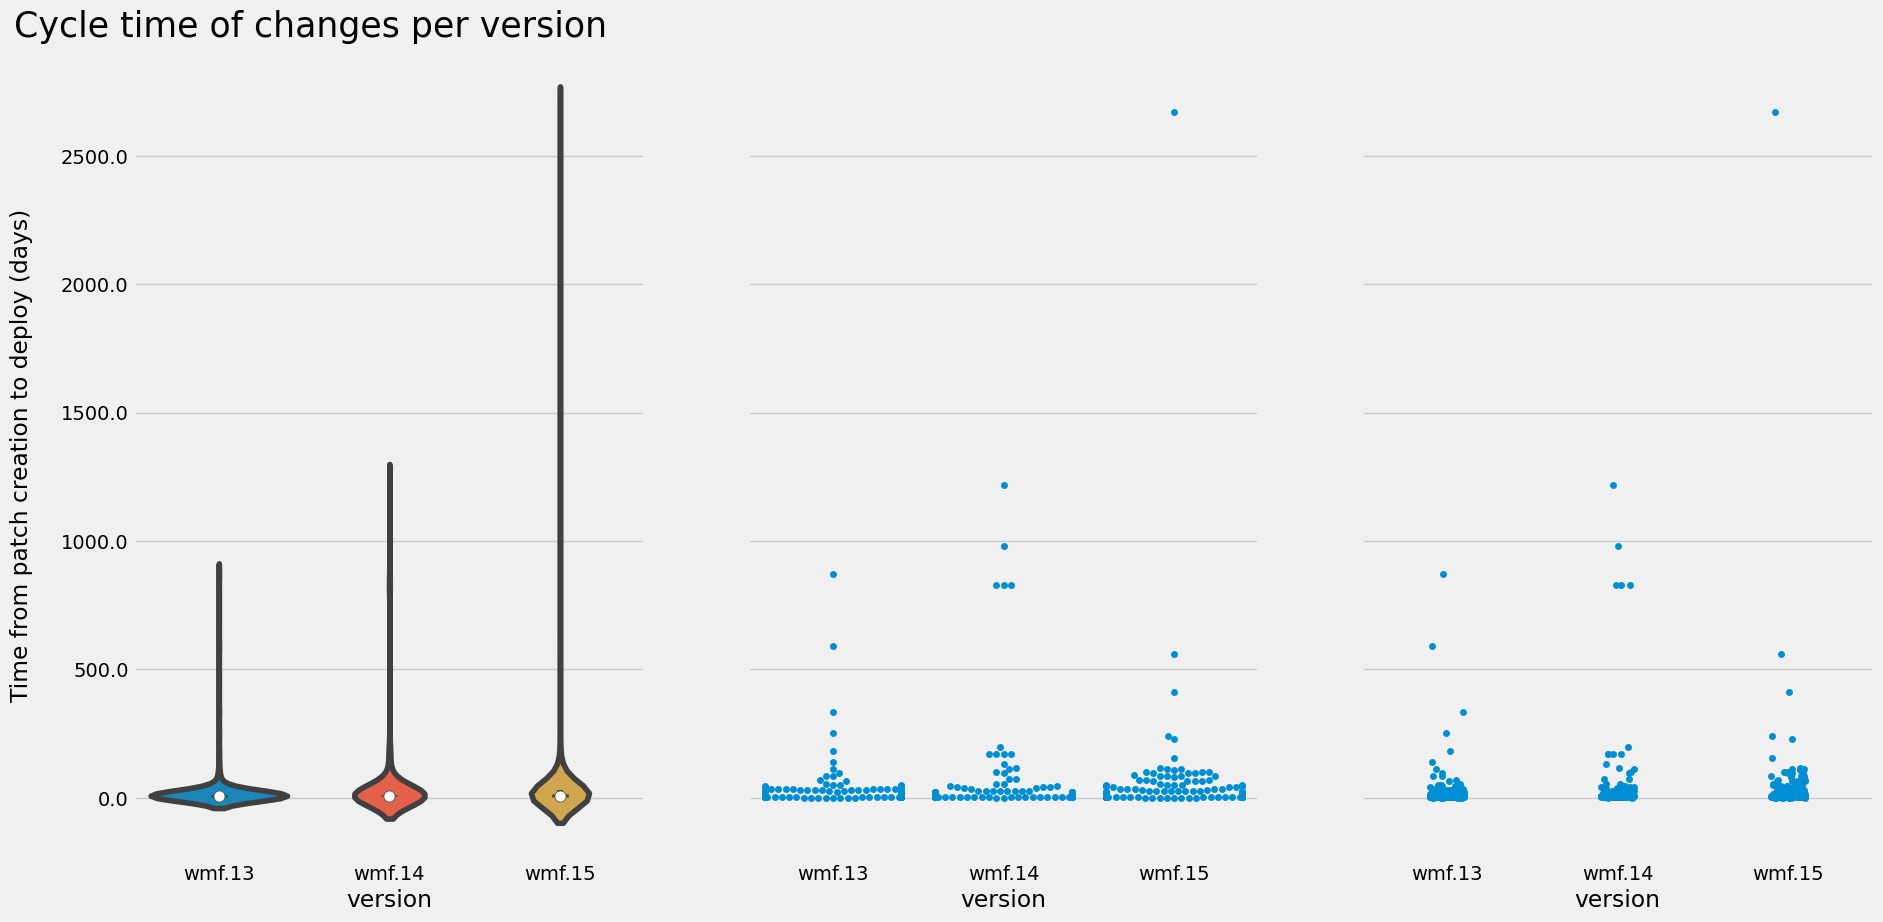

In [21]:
from matplotlib import ticker as mticker
import numpy as np

# Adapted from <https://stackoverflow.com/a/60132262>
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))
sns.violinplot(data=cycle,x='version', y='cycle_time_days', ax=ax[0])
sns.swarmplot(data=cycle,x='version', y='cycle_time_days', ax=ax[1])
sns.stripplot(data=cycle,x='version', y='cycle_time_days', ax=ax[2])
ax[0].set_ylabel('Time from patch creation to deploy (days)', labelpad=20.0)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
plt.suptitle('Cycle time of changes per version', x=0.02, y=.92, ha='left', fontsize=25)
plt.show()

# Cycle time log scale

It's hard to see the majority of our patch's cycletime with the outliers. Here's the log-scale version.

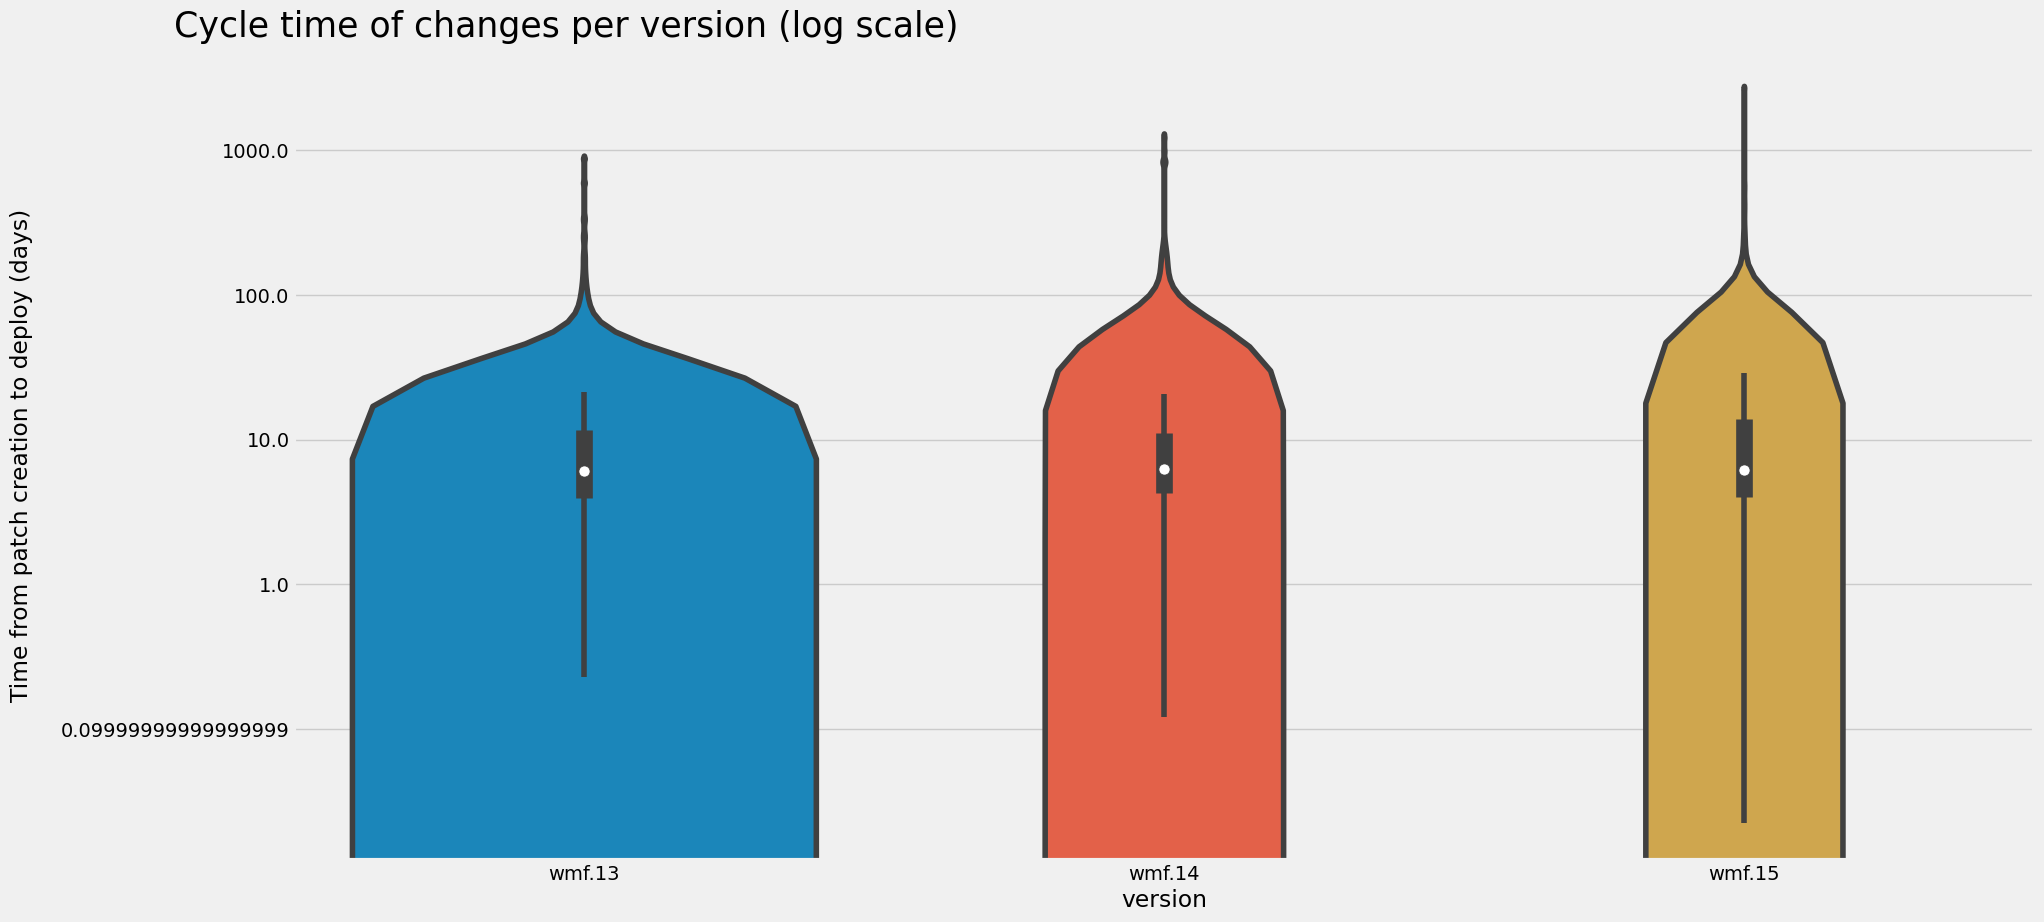

In [22]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(20,10))
ax.set_yscale('log')
sns.violinplot(data=cycle,x='version', y='cycle_time_days', ax=ax)
ax.set_ylabel('Time from patch creation to deploy (days)', labelpad=20.0)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x}"))
plt.suptitle('Cycle time of changes per version (log scale)', x=0.02, y=.92, ha='left', fontsize=25)
plt.show()

## Train bugfixes

> **Backport**
> * v. To retroactively supply a fix, or a new feature, to a previous version of a software product at the same time (or after) supplying it to the current version.
> * n. A commit that is backported

Each train has many backports. Each backport may be supplied to many trains. Backports add features, change feature flags, and fix bugs.

Some backports have tasks associated with them. Some tasks are "bugs" or "errors".

When a backport is associated with a task that is a "bug" or an "error" it's a bugfix. The number of bugfixes per train is a good signal of the number of bugs that were present in that train.

Bugs may persist for many trains; however, if a developer makes a backport, they felt that the bug was severe enough to warrant fixing immediately rather than waiting a week—that's signal about train quality, too.

In [23]:
train_bugs = pd.read_sql('''
select
  version,
  count(b.link) as bug_count
from
  train t
  join bug_train bt on bt.train_id = t.id
  join bug b on bt.bug_id = b.id
group by
  version
order by
  start_time
''', engine)
train_bugs.head()

,version,bug_count
0,1.27.0-wmf.16,3
1,1.27.0-wmf.19,1
2,1.27.0-wmf.21,1
3,1.27.0-wmf.22,2
4,1.27.0-wmf.23,3


### Bug count histogram

Seems to follow the power law

Text(0.5, 1.0, 'Bug count per train')

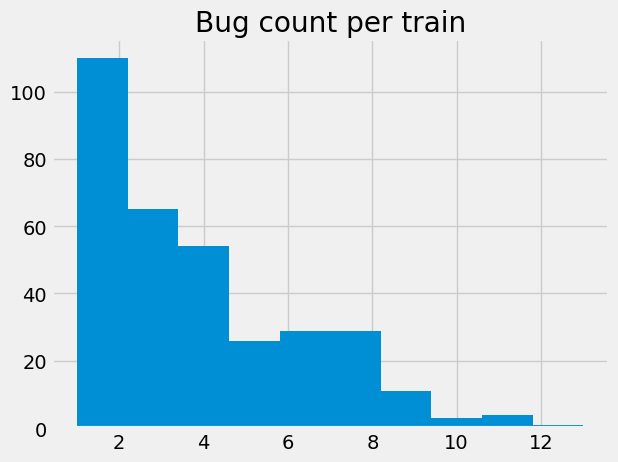

In [24]:
train_bugs.hist()
plt.title('Bug count per train')

In [25]:
train_bugs.sort_values(by="bug_count", ascending=False).head()

,version,bug_count
120,1.34.0-wmf.13,13
119,1.34.0-wmf.11,11
206,1.37.0-wmf.20,11
90,1.32.0-wmf.24,11
194,1.37.0-wmf.5,11


In [26]:
train_bugs = pd.read_sql('''
select
  version,
  count(b.link) as bug_count,
  rollbacks,
  (select count(*) from blocker b where b.train_id = t.id and resolved = 1) as resolved_blockers,
      (select max(time_in_review) from patch p where p.train_id = t.id) as max_time_in_review,
    (select max(comments) from patch where patch.train_id = t.id) as max_comments_per_patch,
    (select max(start_time - created) from patch p where p.train_id = t.id) as max_cycle_time,
  patches
from
  train t
  join bug_train bt on bt.train_id = t.id
  join bug b on bt.bug_id = b.id
group by
  version
order by
  start_time
''', engine)
train_bugs.head()

,version,bug_count,rollbacks,resolved_blockers,max_time_in_review,max_comments_per_patch,max_cycle_time,patches
0,1.27.0-wmf.16,3,1,0,17557313.0,95.0,18128243.0,322
1,1.27.0-wmf.19,1,1,1,58248774.0,45.0,58798558.0,230
2,1.27.0-wmf.21,1,0,0,120956985.0,73.0,120937246.0,180
3,1.27.0-wmf.22,2,0,0,50045244.0,58.0,50160003.0,416
4,1.27.0-wmf.23,3,2,3,20153065.0,40.0,20228209.0,168


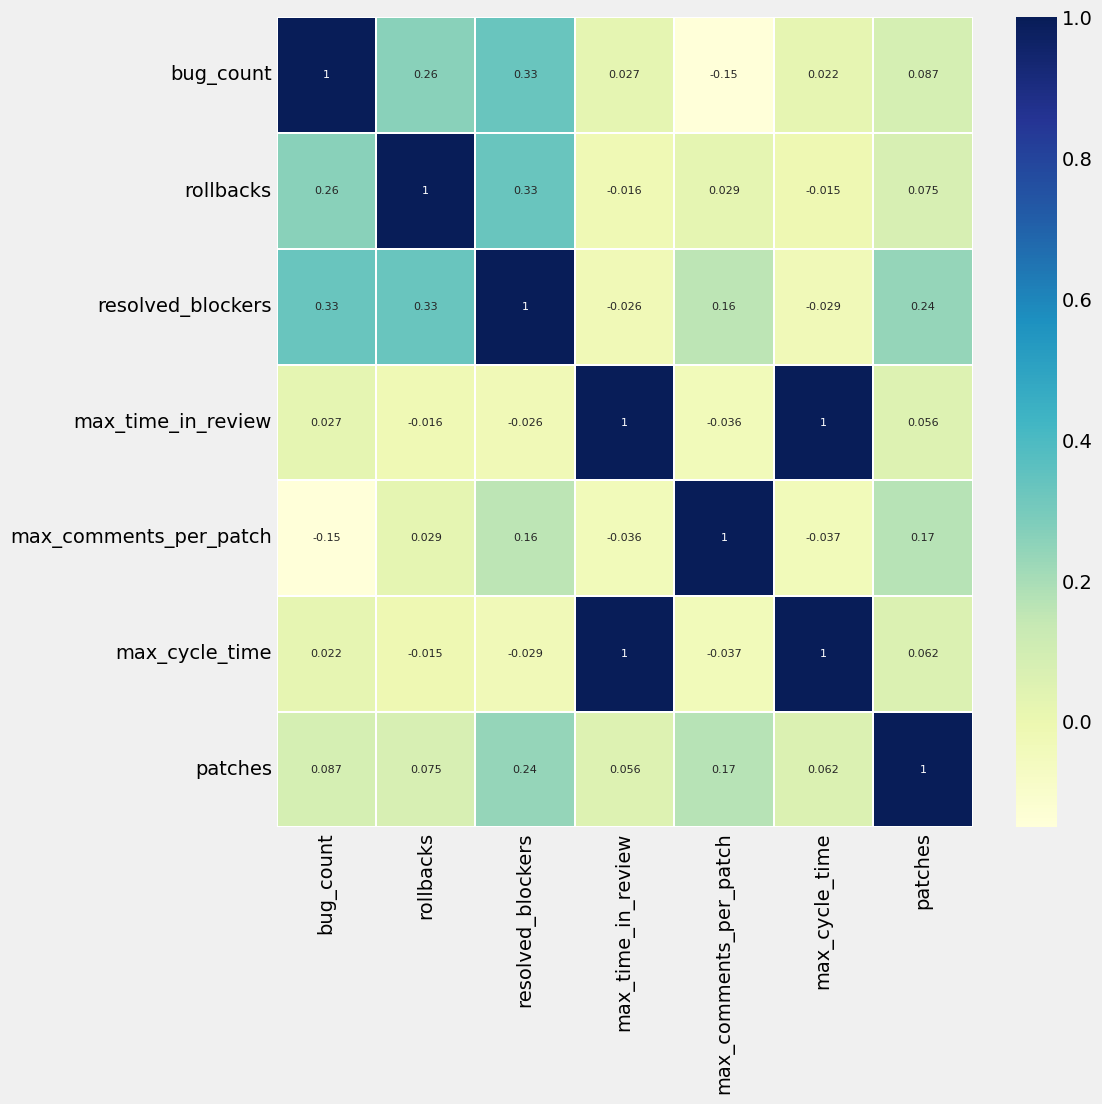

In [27]:
train_bugs_corr = train_bugs.copy(deep=True)
train_bugs_corr.drop(['version'], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(train_bugs_corr.corr(), annot=True, cmap="YlGnBu", linewidths=0.3, annot_kws={"size": 8}, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [28]:
train_bugs[train_bugs['version'] == TRAINS[-1]]

,version,bug_count,rollbacks,resolved_blockers,max_time_in_review,max_comments_per_patch,max_cycle_time,patches
331,1.43.0-wmf.15,3,0,0,230425029.0,54.0,230881547.0,329


## A look at comments per patch

DCaro made an interesting comment on the [the fame blog](https://phabricator.wikimedia.org/phame/post/view/272/diving_into_our_deployment_data/#4166) about this repo. This is my ham-fisted investigation.

In [29]:
comm_dist = pd.read_sql('select version, sum(comments) as comm from patch p join train t on p.train_id = t.id group by t.version', engine)
comm_dist.head()

,version,comm
0,1.27.0-wmf.16,1840
1,1.27.0-wmf.17,1372
2,1.27.0-wmf.18,1204
3,1.27.0-wmf.19,1440
4,1.27.0-wmf.20,1573


Text(0.5, 1.02, 'Comments per Train')

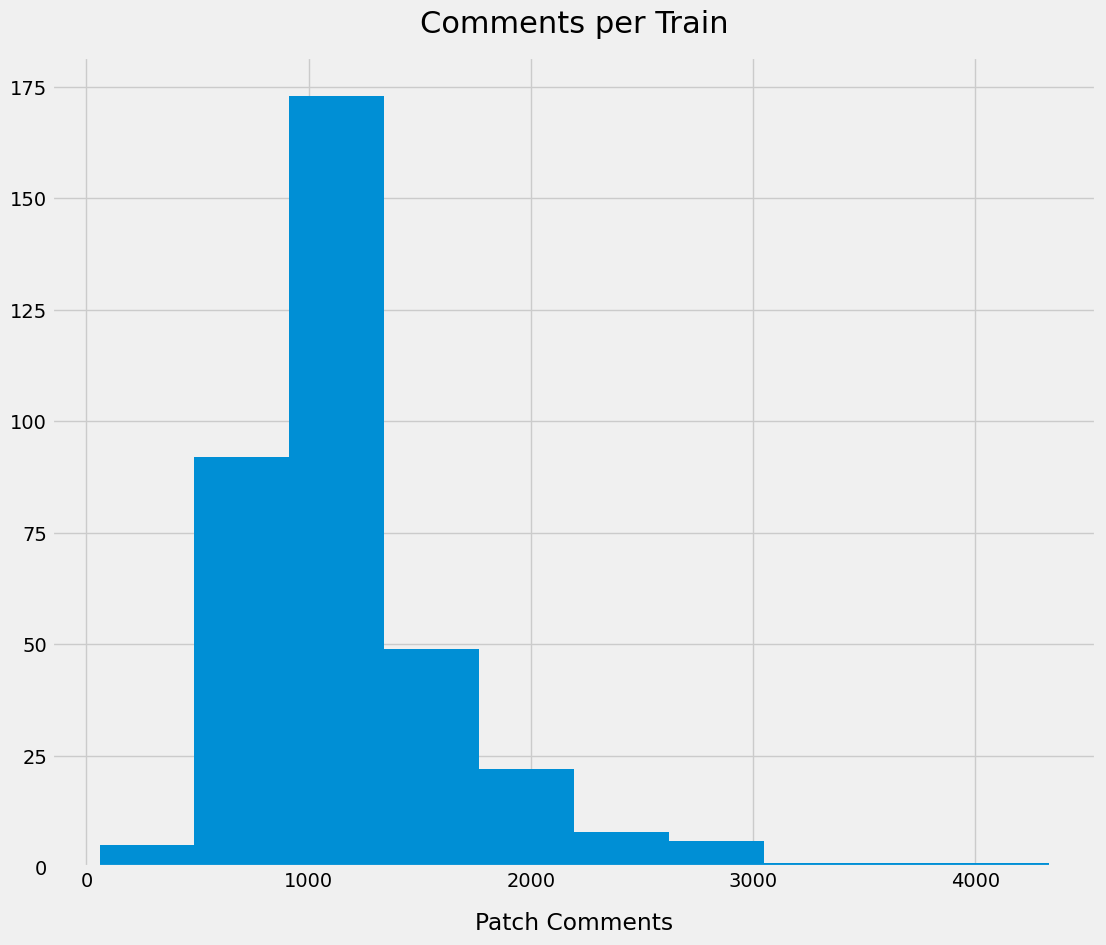

In [30]:
comm_dist.set_index('version')['comm'].hist(figsize=(12, 10))
plt.xlabel("Patch Comments", labelpad=15)
plt.title("Comments per Train", y=1.02, fontsize=22)

In [31]:
pcommdf = pd.read_sql('select link, comments from patch', engine)
pcommdf.head()

,link,comments
0,"https://gerrit.wikimedia.org/r/#/q/ccbfcf28,n,z",1
1,"https://gerrit.wikimedia.org/r/#/q/3302274f,n,z",1
2,"https://gerrit.wikimedia.org/r/#/q/8b5471b5,n,z",0
3,"https://gerrit.wikimedia.org/r/#/q/a6abbb67,n,z",15
4,"https://gerrit.wikimedia.org/r/#/q/af916aad,n,z",3


<Axes: >

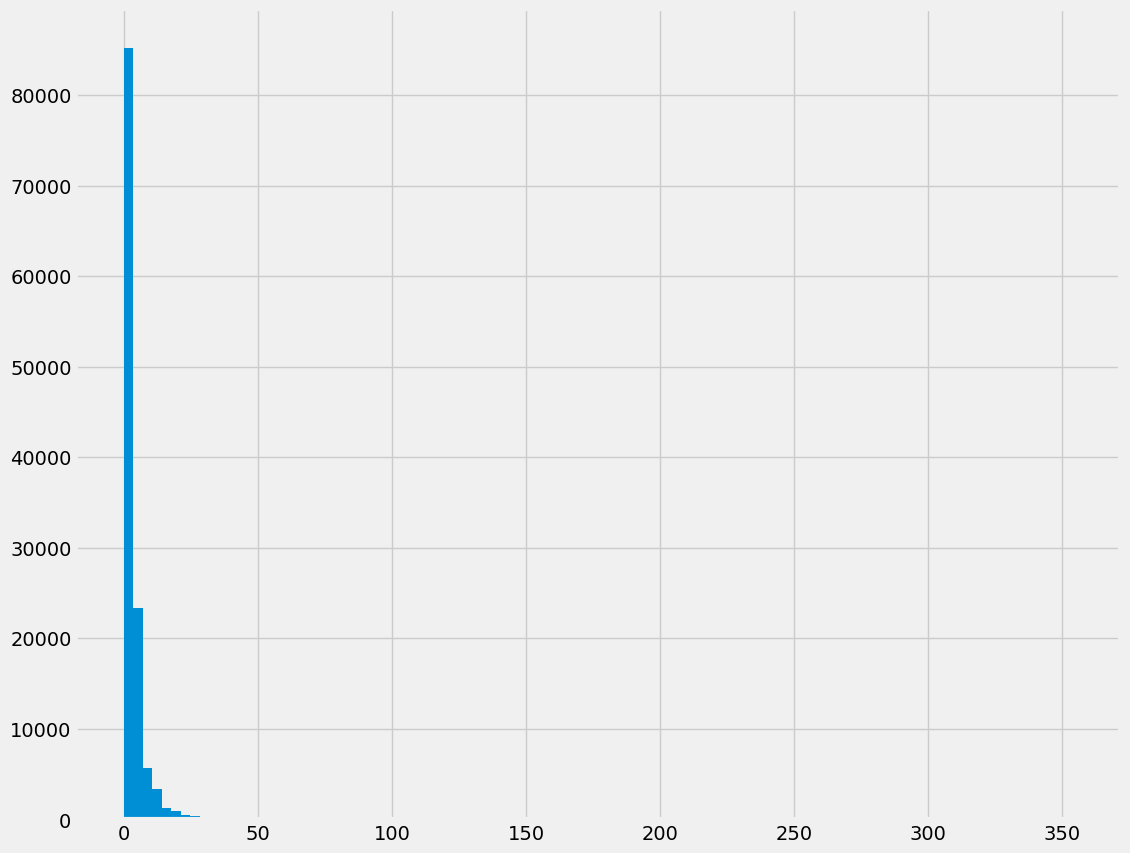

In [32]:
pcommdf.set_index('link')['comments'].hist(figsize=(12, 10),bins=100)

In [33]:
pcommdf.describe()

,comments
count,121104.000000
mean,3.522204
std,5.181298
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,354.000000


In [34]:
# Let's try to remove huge outliers
pcommdf[np.abs(pcommdf.comments - pcommdf.comments.mean()) <= (5 * pcommdf.comments.std())]

,link,comments
0,"https://gerrit.wikimedia.org/r/#/q/ccbfcf28,n,z",1
1,"https://gerrit.wikimedia.org/r/#/q/3302274f,n,z",1
2,"https://gerrit.wikimedia.org/r/#/q/8b5471b5,n,z",0
3,"https://gerrit.wikimedia.org/r/#/q/a6abbb67,n,z",15
4,"https://gerrit.wikimedia.org/r/#/q/af916aad,n,z",3
...,...,...
121099,https://gerrit.wikimedia.org/r/1054611,4
121100,https://gerrit.wikimedia.org/r/1053701,3
121101,https://gerrit.wikimedia.org/r/1052750,4
121102,https://gerrit.wikimedia.org/r/1053392,1


Text(0.5, 1.02, 'Comments per Patch')

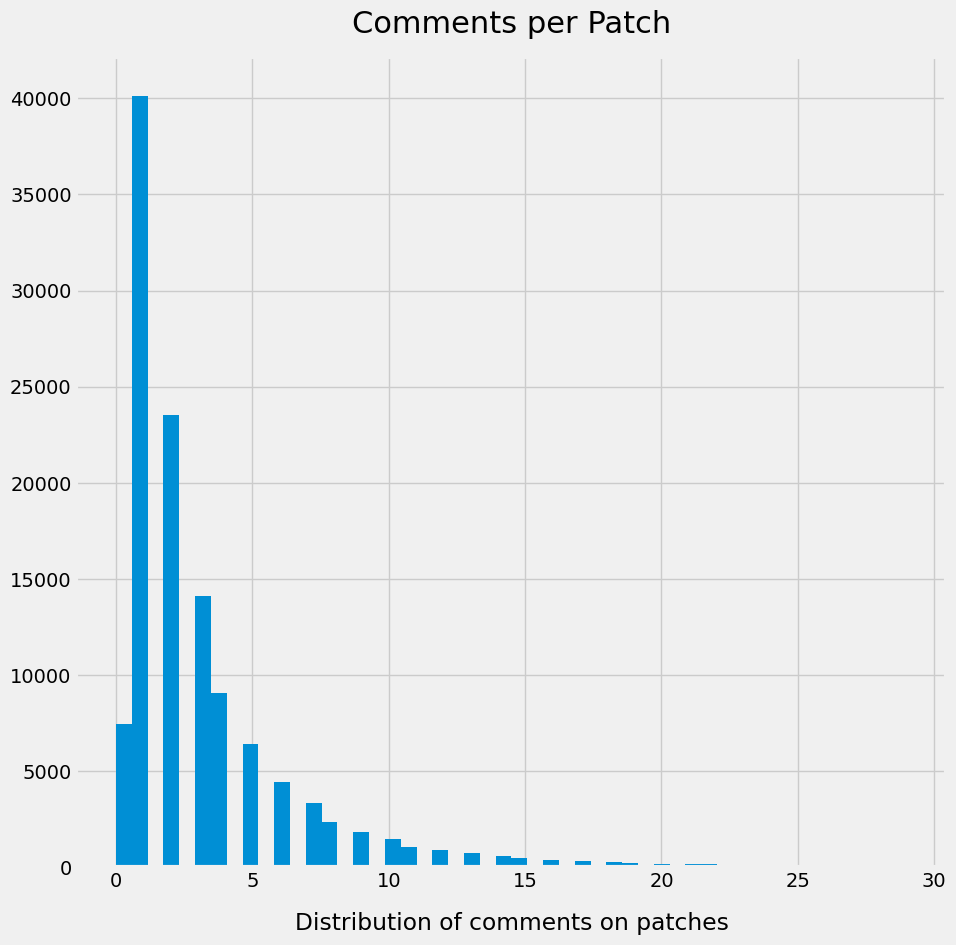

In [35]:
pcommdf[np.abs(pcommdf.comments - pcommdf.comments.mean()) <= (5 * pcommdf.comments.std())].hist(bins=50,figsize=(10, 10))
plt.xlabel("Distribution of comments on patches", labelpad=15)
plt.title("Comments per Patch", y=1.02, fontsize=22)

## Patch authors per train

In [36]:
patch_authors = pd.read_sql('''
SELECT train.version,
    COUNT(DISTINCT patch.owner) as unique_owners
    FROM train
    JOIN patch ON train.id = patch.train_id
    GROUP BY train.id
    ORDER BY start_time;
''', engine)
patch_authors.head()

,version,unique_owners
0,1.27.0-wmf.16,65
1,1.27.0-wmf.17,60
2,1.27.0-wmf.18,61
3,1.27.0-wmf.19,67
4,1.27.0-wmf.20,71


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(-50.0, 0, '1.41.0-wmf.16'),
  Text(0.0, 0, '1.27.0-wmf.16'),
  Text(50.0, 0, '1.30.0-wmf.6'),
  Text(100.0, 0, '1.32.0-wmf.23'),
  Text(150.0, 0, '1.35.0-wmf.11'),
  Text(200.0, 0, '1.36.0-wmf.32'),
  Text(250.0, 0, '1.39.0-wmf.5'),
  Text(300.0, 0, '1.41.0-wmf.7'),
  Text(350.0, 0, '1.43.0-wmf.6'),
  Text(400.0, 0, '')])

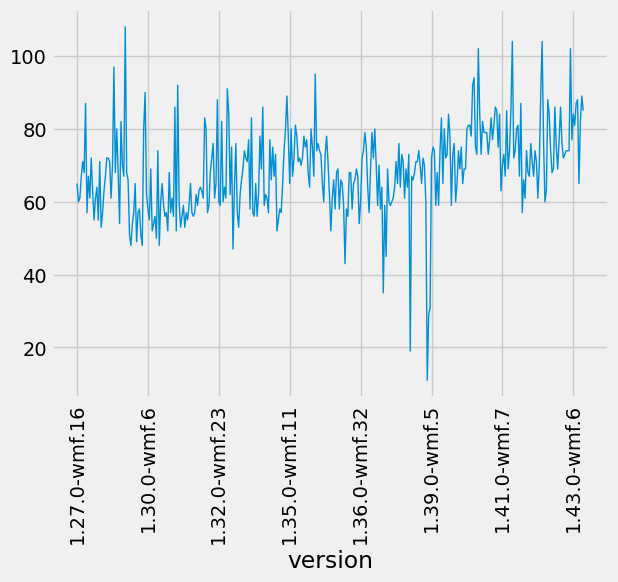

In [37]:
patch_authors.set_index('version').unique_owners.plot(linewidth=1)
plt.xticks(rotation=90)

In [38]:
patch_authors.describe()

,unique_owners
count,358.000000
mean,68.480447
std,12.063948
min,11.000000
25%,60.000000
50%,68.000000
75%,75.000000
max,108.000000


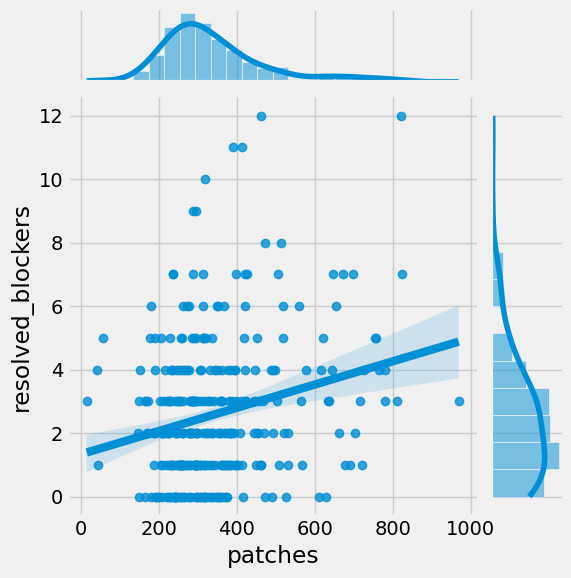

In [39]:
sns.jointplot(data=train_bugs, x='patches', y='resolved_blockers', kind='reg')

## Bugs escaping into production

Everytime we backport a fix, it counts as a bug. And it's a bug we missed before the code went to production. This is known as an "escape."

In [40]:
escapes = pd.read_sql('''
select
  version,
  b.link
from
  bug_train bt
  join train t on t.id = bt.train_id
  join bug b on bt.bug_id = b.id
  join bug_bug_patch bbp on bbp.bug_id = b.id
  join bug_patch bp on bp.id = bbp.bug_patch_id
  join bug_file bf on bp.id = bf.bug_patch_id
group by
  version, b.link;
''', engine)
escapes.head()

,version,link
0,1.27.0-wmf.16,https://phabricator.wikimedia.org/T129641
1,1.27.0-wmf.16,https://phabricator.wikimedia.org/T129704
2,1.27.0-wmf.16,https://phabricator.wikimedia.org/T129715
3,1.27.0-wmf.19,https://phabricator.wikimedia.org/T131283
4,1.27.0-wmf.21,https://phabricator.wikimedia.org/T132645


In [41]:
escapes.version.value_counts()

version
1.34.0-wmf.13    13
1.37.0-wmf.5     11
1.34.0-wmf.11    11
1.37.0-wmf.20    11
1.32.0-wmf.24    11
                 ..
1.32.0-wmf.7      1
1.29.0-wmf.18     1
1.31.0-wmf.22     1
1.35.0-wmf.25     1
1.35.0-wmf.2      1
Name: count, Length: 332, dtype: int64

In [42]:
df_escapes = escapes.version.value_counts(dropna=True, sort=False).rename_axis('version').to_frame('counts')
# sns.lineplot(df_escapes, x='version')
df_escapes.head()

,counts
version,
1.27.0-wmf.16,3
1.27.0-wmf.19,1
1.27.0-wmf.21,1
1.27.0-wmf.22,2
1.27.0-wmf.23,3


In [43]:
df_escapes = df_escapes.reset_index()
df_escapes.head()

,version,counts
0,1.27.0-wmf.16,3
1,1.27.0-wmf.19,1
2,1.27.0-wmf.21,1
3,1.27.0-wmf.22,2
4,1.27.0-wmf.23,3


In [44]:
df_escapes['counts'] = pd.to_numeric(df_escapes['counts'], errors='coerce')
df_escapes['version'] = df_escapes['version'].astype(str)
df_escapes.head()

,version,counts
0,1.27.0-wmf.16,3
1,1.27.0-wmf.19,1
2,1.27.0-wmf.21,1
3,1.27.0-wmf.22,2
4,1.27.0-wmf.23,3


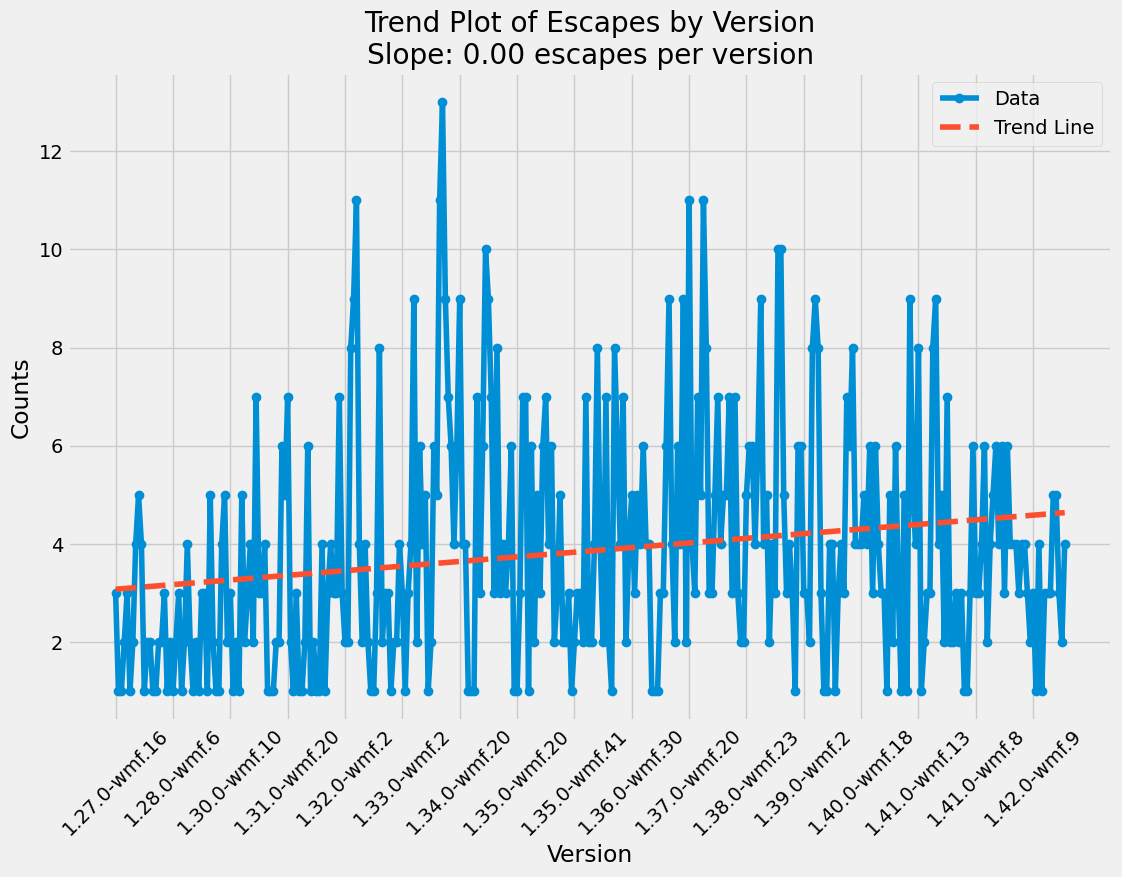

In [45]:
import numpy as np

# Select a subset of versions to display
subset_versions = df_escapes['version'].unique()[::1]  # Every version...just make a copy

# Filter the DataFrame to include only the subset of versions
df_subset = df_escapes[df_escapes['version'].isin(subset_versions)]

# Extract x and y values from the DataFrame
x = df_subset['version']
y = df_subset['counts']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the line plot
ax.plot(x, y, marker='o', linestyle='-', label='Data')

# Calculate the trend line using polynomial regression (degree=1)
coefficients = np.polyfit(np.arange(len(x)), y, deg=1)
trendline = np.poly1d(coefficients)
ax.plot(x, trendline(np.arange(len(x))), linestyle='--', label='Trend Line')

# Calculate the slope of the trend line
slope = coefficients[0]

# Set labels and title
ax.set_xlabel('Version')
ax.set_ylabel('Counts')
ax.set_title(f'Trend Plot of Escapes by Version\nSlope: {slope:.2f} escapes per version')

# Reduce the number of x-axis tick labels
tick_positions = np.arange(0, len(x), step=20)  # Adjust the step value to show desired number of labels
tick_labels = x[tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45)

# Display legend
ax.legend()

# Show the plot
plt.show()